## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

___

## 2. Prepare the Dataset

- Use MNIST as a typical example, normalize it to [-1, 1] for better GAN performance

This command creates a **data transformation pipeline** typically used in image preprocessing for deep learning tasks with libraries like PyTorch.

Here’s what the command does, step-by-step:

1. **`transforms.Compose([...])`**  
   This wraps multiple transformations into one. It applies them sequentially to the input data.

2. **`transforms.ToTensor()`**  
   Converts a PIL image or NumPy ndarray into a PyTorch tensor. It also scales pixel values from the range  to [0.0, 1.0].

3. **`transforms.Normalize(mean=(0.5,), std=(0.5,))`**  
   Normalizes the tensor by subtracting the mean and dividing by the standard deviation for each channel. Here, the single value `(0.5,)` corresponds to one channel (like grayscale).

   Since the pixel values are between 0 and 1 after `ToTensor()`, normalization with mean=0.5 and std=0.5 converts them roughly to the range [-1, 1] using this formula:

   $$
   \text{normalized\_pixel} = \frac{\text{pixel} - 0.5}{0.5}
   $$

### Purpose of this command:

- **Convert images to tensors** (making them compatible with PyTorch models).
- **Normalize pixel intensity values** so the model trains more effectively (helps with convergence and stabilizes training by standardizing input).

This transformation is common in training neural networks on datasets like MNIST or grayscale images since it processes the image into a normalized tensor input suitable for the model.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

This command creates a **training dataset object** for the MNIST dataset using PyTorch’s `torchvision.datasets` module.

Here’s a breakdown of the command:

- **`datasets.MNIST(...)`**  
  This loads the MNIST handwritten digit dataset, which contains grayscale images of digits (0–9).

- **`root='./data'`**  
  Specifies the directory where the MNIST data will be stored or loaded from. If the data is not already present, it will be downloaded to this folder.

- **`train=True`**  
  Indicates that this dataset object should load the **training split** of MNIST (60,000 images). If set to `False`, it would load the test split (10,000 images).

- **`download=True`**  
  If the dataset isn’t already present in the specified `root` folder, PyTorch will automatically download it from the internet.

- **`transform=transform`**  
  Applies the previously defined transformations (such as conversion to tensor and normalization) to every image when it is loaded. This preprocesses the images so they're ready for training.

### Purpose of this command:

- It **loads** the MNIST training dataset, downloading it if necessary.
- It **applies the defined transformations** (like converting images to tensors and normalizing) on the data.
- It prepares the dataset in a format suitable for training a PyTorch model.

In short, this command **sets up your training data pipeline** for feeding images into a neural network.

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

This command creates a **DataLoader** object from the previously defined `train_dataset` (MNIST training dataset in this case).

Here’s what it does:

- **`DataLoader(train_dataset, batch_size=64, shuffle=True)`**  
  This wraps the dataset in a convenient iterator for training machine learning models.

- **`batch_size=64`**  
  Specifies that data will be loaded in batches of 64 samples. Instead of passing one image at a time, the model receives 64 images in each training step, which is efficient and stabilizes training.

- **`shuffle=True`**  
  Means the dataset will be shuffled at the start of each epoch. Shuffling helps the model see the data in a different order each time, which improves training by reducing overfitting and increasing generalization.

### Purpose of this command:

- To **batch the dataset** enabling efficient processing and training.
- To **shuffle the training data** so the model does not learn the order of data, which promotes better generalization.
- To provide an **easily iterable object** that returns batches of transformed images and their labels, ready for training.

In summary, this command sets up the training pipeline to feed the model mini-batches of shuffled data for training. It abstracts away loading and batching complexities so the training loop can run smoothly and efficiently.

In [4]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

___

## 3. Define the Generator

- **Generator:** Turns noisy random input into a 28x28 image.

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Tanh()  # Output between -1 and 1
        )
    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)

___

## 4. Define the Discriminator

- **Discriminator:** Predicts if input image is real or fake.

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

___

## 5. Initialize networks

- Set your device (GPU if available)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
noise_dim = 100
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

___

## 6. Set Loss and Optimizers

In [9]:
lr = 0.0002

In [10]:
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [11]:
criterion = nn.BCELoss()

___

## 7. Training Loop

For each batch:
- Train D: on real images (label=1) and fake images (label=0).
- Train G: try to make D classify generated images as real (label=1).

In [12]:
num_epochs = 100

In [13]:
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        # Labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        ### Train Discriminator ##
        discriminator_optimizer.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)

        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        discriminator_optimizer.step()

        ### Train Generator ##
        generator_optimizer.zero_grad()
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)  # Fool the discriminator!
        g_loss.backward()
        generator_optimizer.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

Epoch [1/100], Step [0/938], D Loss: 1.5021, G Loss: 0.6811
Epoch [1/100], Step [100/938], D Loss: 1.0657, G Loss: 0.5572
Epoch [1/100], Step [200/938], D Loss: 1.1630, G Loss: 0.5739
Epoch [1/100], Step [300/938], D Loss: 1.1649, G Loss: 0.6321
Epoch [1/100], Step [400/938], D Loss: 1.0775, G Loss: 0.7812
Epoch [1/100], Step [500/938], D Loss: 0.9454, G Loss: 0.8511
Epoch [1/100], Step [600/938], D Loss: 0.8461, G Loss: 1.0556
Epoch [1/100], Step [700/938], D Loss: 0.8821, G Loss: 1.0138
Epoch [1/100], Step [800/938], D Loss: 0.9163, G Loss: 1.0267
Epoch [1/100], Step [900/938], D Loss: 0.9131, G Loss: 0.9326
Epoch [2/100], Step [0/938], D Loss: 0.8923, G Loss: 1.1721
Epoch [2/100], Step [100/938], D Loss: 0.9638, G Loss: 0.8203
Epoch [2/100], Step [200/938], D Loss: 0.8644, G Loss: 1.0128
Epoch [2/100], Step [300/938], D Loss: 0.7991, G Loss: 1.2784
Epoch [2/100], Step [400/938], D Loss: 0.8533, G Loss: 1.0733
Epoch [2/100], Step [500/938], D Loss: 0.8369, G Loss: 1.1190
Epoch [2/100

___

## 8. Generate and Visualize Images

In [14]:
generator.eval()
noise = torch.randn(16, noise_dim, device=device)

In [15]:
fake_images = generator(noise)
fake_images = fake_images.view(-1, 1, 28, 28).cpu().detach()
fake_images = (fake_images + 1) / 2

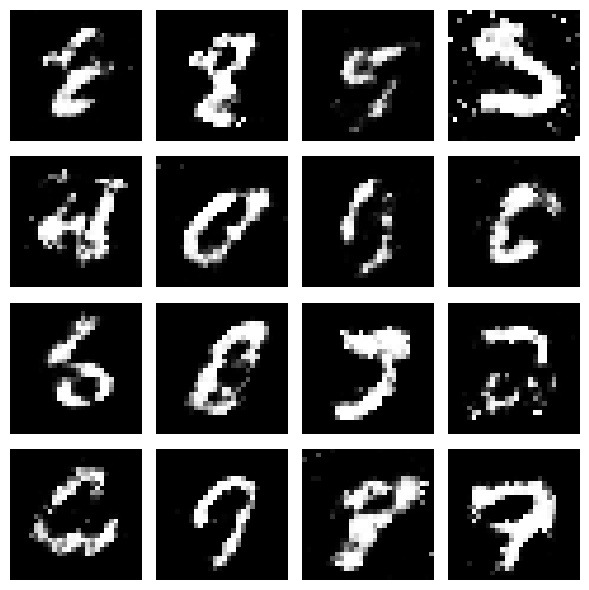

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(16):
    ax = axes[i // 4, i % 4]
    ax.imshow(fake_images[i][0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

___